### Kaggle Link
https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

### Data Description

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., *ind*, *reg*, *car*, *calc*). In addition, feature names include the postfix **bin** to indicate binary features and **cat** to indicate categorical features. Features without these designations are either continuous or ordinal. Values of *-1* indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings

sns.set(style='whitegrid')

pd.set_option('display.max_columns', None)  

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df_train = pd.read_csv('../Data/Kaggle/PortoSeguro/train.csv')
df_test  = pd.read_csv('../Data/Kaggle/PortoSeguro/test.csv')

In [4]:
df_ids = df_test['id']
for df in [df_train, df_test]:
    df.drop(['id'], axis=1, inplace=True)

In [5]:
df_train = df_train.replace(-1, np.NaN)

In [6]:
len(df_train)

595212

In [7]:
df_train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,2,2.0,5,1.0,0.0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10.0,1.0,NaN,0,1.0,4,1.0,0,0.0,1,12,2.0,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,0,1,1.0,7,0.0,0.0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11.0,1.0,NaN,0,NaN,11,1.0,1,2.0,1,19,3.0,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,0,5,4.0,9,1.0,0.0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,NaN,7.0,1.0,NaN,0,NaN,14,1.0,1,2.0,1,60,1.0,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,0,0,1.0,2,0.0,0.0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7.0,1.0,0.0,0,1.0,11,1.0,1,3.0,1,104,1.0,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,0,0,2.0,0,1.0,0.0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11.0,1.0,NaN,0,NaN,14,1.0,1,2.0,1,82,3.0,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


### Exploratory Analysis

#### Missing Values

In [8]:
missing_columns = df_train.columns[df_train.isnull().any()].tolist()

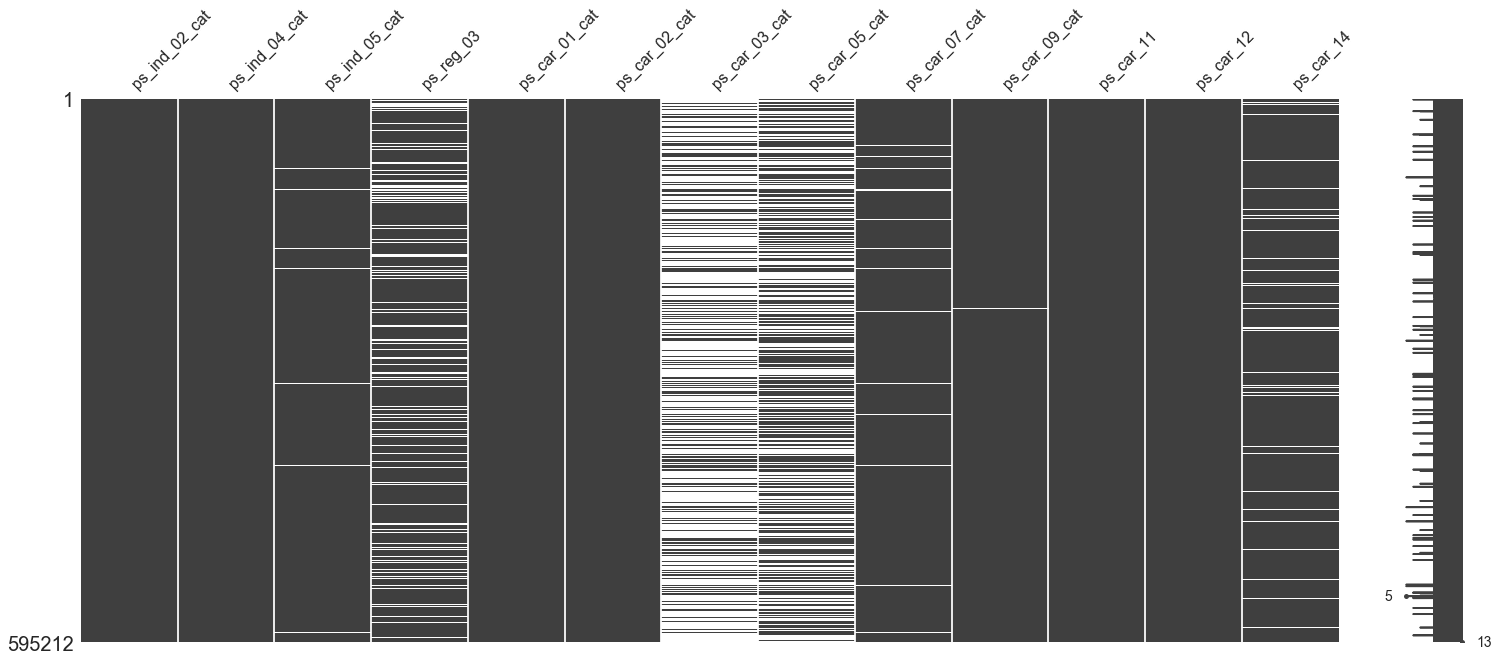

In [9]:
msno.matrix(df_train[missing_columns])

In [6]:
binary_feat = [c for c in df_train.columns if c.endswith('bin')]
categorical_feat = [c for c in df_train.columns if c.endswith('cat')]
other_feat = df_train.columns.difference(binary_feat + categorical_feat).values

In [7]:
for col in categorical_feat:
    df_train[col].fillna(value=df_train[col].mode()[0], inplace=True)
    df_test[col].fillna(value=df_test[col].mode()[0], inplace=True)
    
for col in binary_feat:
    df_train[col].fillna(value=df_train[col].mode()[0], inplace=True)
    df_test[col].fillna(value=df_test[col].mode()[0], inplace=True)
    
for col in other_feat:
    if col != 'target':
        df_train[col].fillna(value=df_train[col].mean(), inplace=True)
        df_test[col].fillna(value=df_test[col].mean(), inplace=True)

In [8]:
df_train.columns[df_train.isnull().any()].tolist()

[]

In [9]:
df_test.columns[df_test.isnull().any()].tolist()

[]

#### Distributions

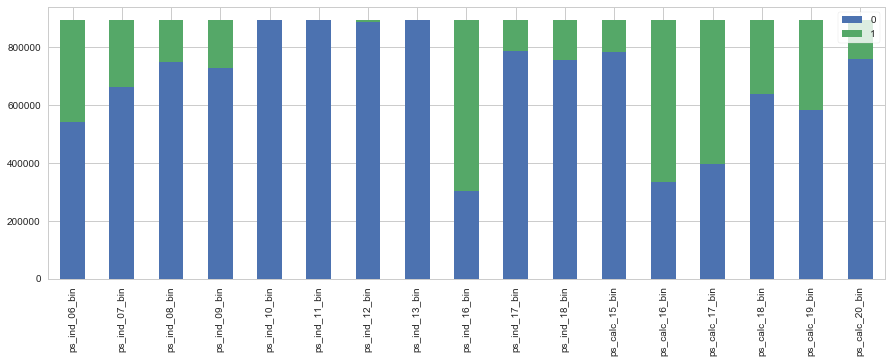

In [14]:
df[binary_feat].agg(pd.Series.value_counts).T.plot.bar(stacked=True, figsize=(15, 5), rot=90, grid=True) 
plt.legend(frameon=True)

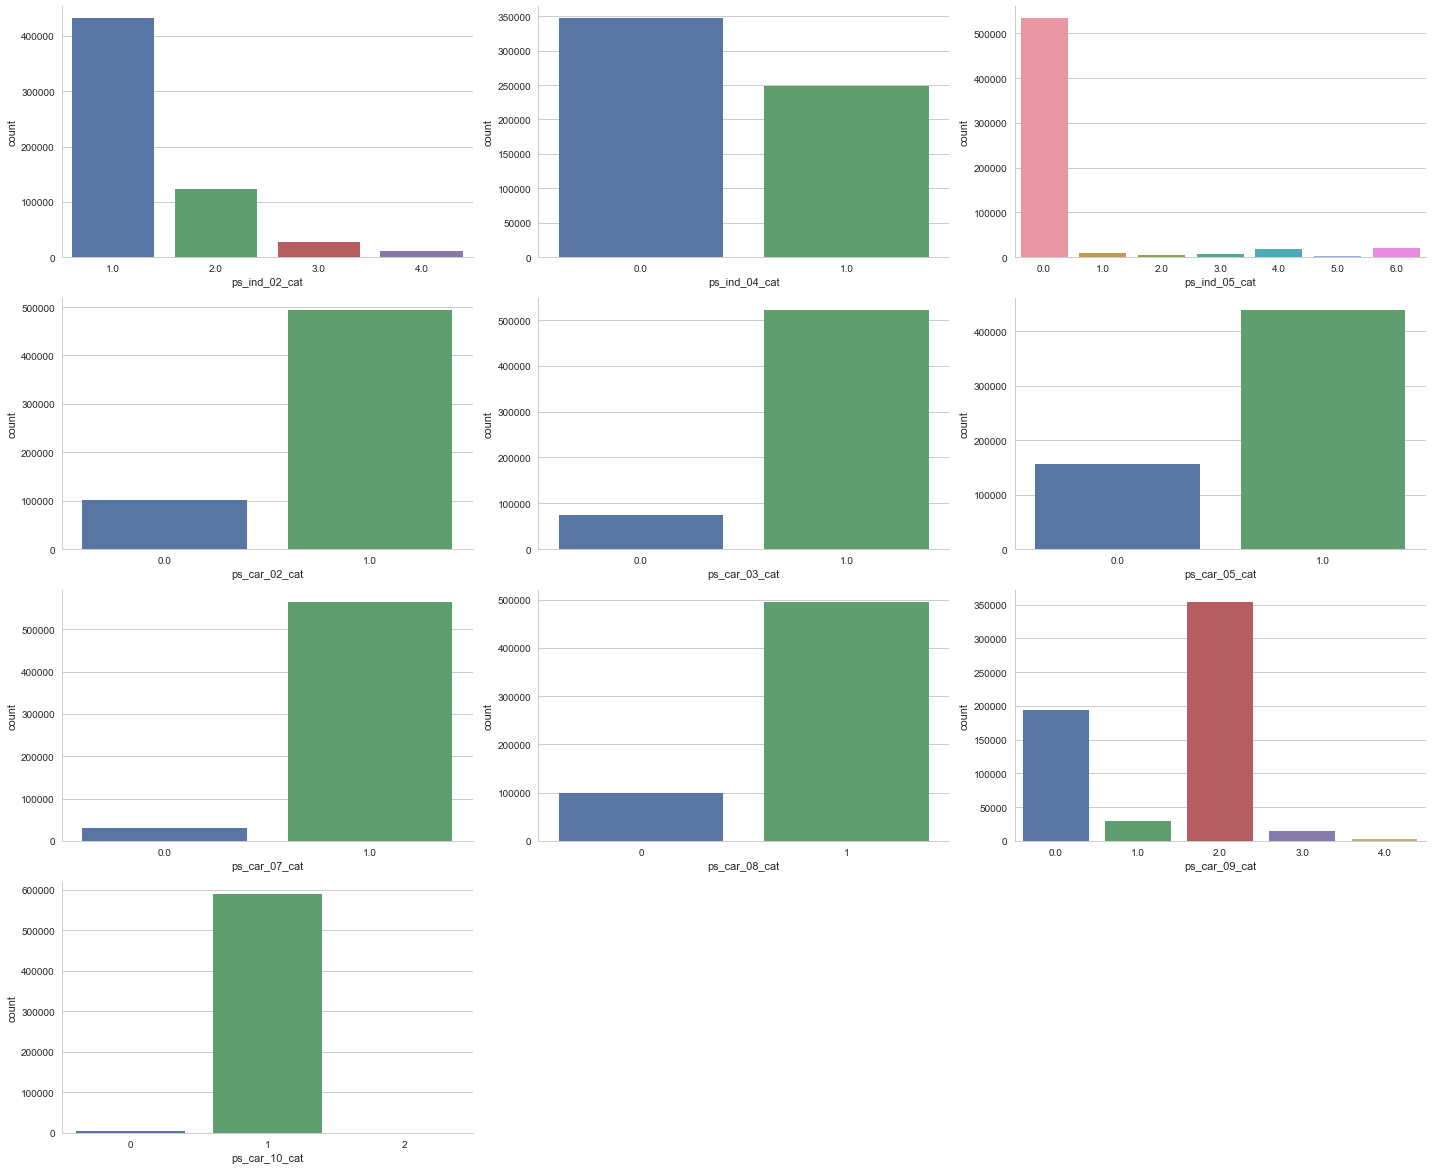

In [15]:
plt.figure(figsize=(20, 20))
i = 0
for c in categorical_feat:
    if df_train[c].nunique() < 10:
        ax = plt.subplot(5, 3, i+1)
        sns.countplot(df_train[c])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        i += 1
plt.tight_layout()

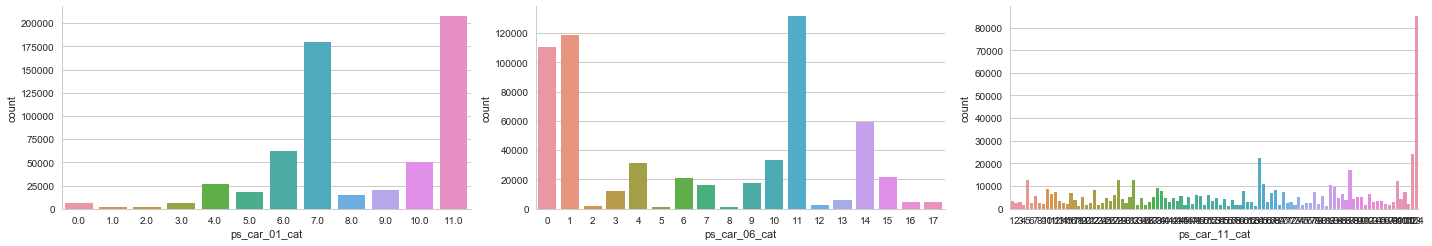

In [16]:
plt.figure(figsize=(20, 20))
i = 0
for c in categorical_feat:
    if df_train[c].nunique() > 10:
        ax = plt.subplot(6, 3, i+1)
        sns.countplot(df_train[c])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        i += 1
plt.tight_layout()

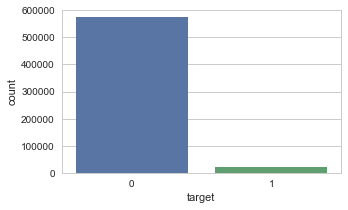

In [17]:
plt.figure(figsize=(5, 3))
sns.countplot(df_train['target'])

#### Correlations

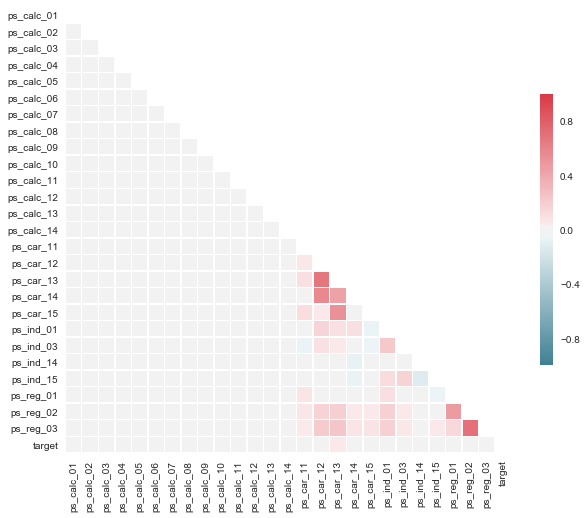

In [18]:
corr = df_train[other_feat].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

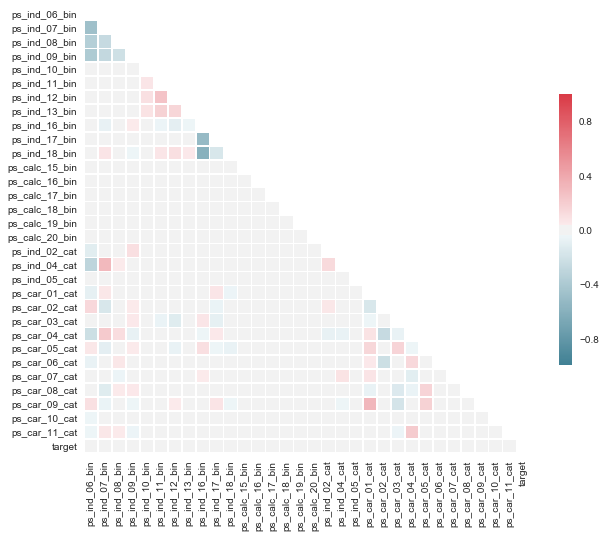

In [19]:
corr = df_train[binary_feat+categorical_feat+['target']].corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

As can be seen, *ps\_calc\_\** doesn't seen to correlate to anything and will be drop to reduce the curse of dimensionality. We will also drop columns with too much NaNs.

In [10]:
unwanted = list(df_train.columns[df_train.columns.str.startswith('ps_calc_')]) + ['ps_car_03_cat', 'ps_car_05_cat']
df_train = df_train.drop(unwanted, axis=1)  
df_test =  df_test.drop(unwanted, axis=1)  

*There are multiple phenomena referred to by this name in domains such as numerical analysis, sampling, combinatorics, machine learning, data mining, and databases. The common theme of these problems is that when the dimensionality increases, the volume of the space increases so fast that the available data become sparse. This sparsity is problematic for any method that requires statistical significance. In order to obtain a statistically sound and reliable result, the amount of data needed to support the result often grows exponentially with the dimensionality. Also, organizing and searching data often relies on detecting areas where objects form groups with similar properties; in high dimensional data, however, all objects appear to be sparse and dissimilar in many ways, which prevents common data organization strategies from being efficient.*

### Feature Engineering

In [11]:
for df in [df_train, df_test]:
    df['ps_car_13_ps_reg_03'] = df['ps_car_13'] * df['ps_reg_03']
    df['ps_reg_mult'] = df['ps_reg_01'] * df['ps_reg_02'] * df['ps_reg_03']
    df['ps_ind_bin_sum'] = df['ps_ind_06_bin'] + df['ps_ind_07_bin'] + df['ps_ind_08_bin'] + df['ps_ind_09_bin'] + df['ps_ind_10_bin'] + \
        df['ps_ind_11_bin'] + df['ps_ind_12_bin'] + df['ps_ind_13_bin'] + df['ps_ind_16_bin'] + df['ps_ind_17_bin'] + df['ps_ind_18_bin']

In [12]:
df_train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_car_13_ps_reg_03,ps_reg_mult,ps_ind_bin_sum
0,0,2,2.0,5,1.0,0.0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10.0,1.0,0,4,1.0,0,0.0,1,12,2.0,0.400000,0.883679,0.370810,3.605551,0.634544,0.100530,2
1,0,1,1.0,7,0.0,0.0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11.0,1.0,0,11,1.0,1,2.0,1,19,3.0,0.316228,0.618817,0.388716,2.449490,0.474062,0.245145,2
2,0,5,4.0,9,1.0,0.0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,0.894047,7.0,1.0,0,14,1.0,1,2.0,1,60,1.0,0.316228,0.641586,0.347275,3.316625,0.573608,0.000000,2
3,0,0,1.0,2,0.0,0.0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7.0,1.0,0,11,1.0,1,3.0,1,104,1.0,0.374166,0.542949,0.294958,2.000000,0.315425,0.104571,2
4,0,0,2.0,0,1.0,0.0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11.0,1.0,0,14,1.0,1,2.0,1,82,3.0,0.316070,0.565832,0.365103,2.000000,0.475728,0.353119,2


### Data Preparation

In [13]:
X_train = df_train.drop(['target'], axis=1)
y_train = df_train['target']
X_valid = df_test

Scaling numerical features.

In [14]:
from sklearn.preprocessing import StandardScaler

categorical_feat = [c for c in X_train.columns if 'cat' in c]
non_categorical_feat = X_train.columns.difference(categorical_feat)

scaler = StandardScaler()
X_train.loc[:, non_categorical_feat] = scaler.fit_transform(X_train[non_categorical_feat])
X_valid.loc[:, non_categorical_feat] = scaler.transform(X_valid[non_categorical_feat])

One hot encoding categorical features.

In [15]:
train_objs_num = len(X_train)

dataset = pd.concat(objs=[X_train, X_valid], axis=0)   
categorical_feat = [c for c in dataset.columns if c.endswith('cat')]
dataset = pd.get_dummies(columns=categorical_feat, data=dataset)

X_train = dataset[:train_objs_num]
X_valid = dataset[train_objs_num:]

In [16]:
X_train.head()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_car_13_ps_reg_03,ps_reg_mult,ps_ind_bin_sum,ps_ind_02_cat_-1.0,ps_ind_02_cat_1.0,ps_ind_02_cat_2.0,ps_ind_02_cat_3.0,ps_ind_02_cat_4.0,ps_ind_04_cat_-1.0,ps_ind_04_cat_0.0,ps_ind_04_cat_1.0,ps_ind_05_cat_-1.0,ps_ind_05_cat_0.0,ps_ind_05_cat_1.0,ps_ind_05_cat_2.0,ps_ind_05_cat_3.0,ps_ind_05_cat_4.0,ps_ind_05_cat_5.0,ps_ind_05_cat_6.0,ps_car_01_cat_-1.0,ps_car_01_cat_0.0,ps_car_01_cat_1.0,ps_car_01_cat_2.0,ps_car_01_cat_3.0,ps_car_01_cat_4.0,ps_car_01_cat_5.0,ps_car_01_cat_6.0,ps_car_01_cat_7.0,ps_car_01_cat_8.0,ps_car_01_cat_9.0,ps_car_01_cat_10.0,ps_car_01_cat_11.0,ps_car_02_cat_-1.0,ps_car_02_cat_0.0,ps_car_02_cat_1.0,ps_car_04_cat_0,ps_car_04_cat_1,ps_car_04_cat_2,ps_car_04_cat_3,ps_car_04_cat_4,ps_car_04_cat_5,ps_car_04_cat_6,ps_car_04_cat_7,ps_car_04_cat_8,ps_car_04_cat_9,ps_car_06_cat_0,ps_car_06_cat_1,ps_car_06_cat_2,ps_car_06_cat_3,ps_car_06_cat_4,ps_car_06_cat_5,ps_car_06_cat_6,ps_car_06_cat_7,ps_car_06_cat_8,ps_car_06_cat_9,ps_car_06_cat_10,ps_car_06_cat_11,ps_car_06_cat_12,ps_car_06_cat_13,ps_car_06_cat_14,ps_car_06_cat_15,ps_car_06_cat_16,ps_car_06_cat_17,ps_car_07_cat_-1.0,ps_car_07_cat_0.0,ps_car_07_cat_1.0,ps_car_08_cat_0,ps_car_08_cat_1,ps_car_09_cat_-1.0,ps_car_09_cat_0.0,ps_car_09_cat_1.0,ps_car_09_cat_2.0,ps_car_09_cat_3.0,ps_car_09_cat_4.0,ps_car_10_cat_0,ps_car_10_cat_1,ps_car_10_cat_2,ps_car_11_cat_1,ps_car_11_cat_2,ps_car_11_cat_3,ps_car_11_cat_4,ps_car_11_cat_5,ps_car_11_cat_6,ps_car_11_cat_7,ps_car_11_cat_8,ps_car_11_cat_9,ps_car_11_cat_10,ps_car_11_cat_11,ps_car_11_cat_12,ps_car_11_cat_13,ps_car_11_cat_14,ps_car_11_cat_15,ps_car_11_cat_16,ps_car_11_cat_17,ps_car_11_cat_18,ps_car_11_cat_19,ps_car_11_cat_20,ps_car_11_cat_21,ps_car_11_cat_22,ps_car_11_cat_23,ps_car_11_cat_24,ps_car_11_cat_25,ps_car_11_cat_26,ps_car_11_cat_27,ps_car_11_cat_28,ps_car_11_cat_29,ps_car_11_cat_30,ps_car_11_cat_31,ps_car_11_cat_32,ps_car_11_cat_33,ps_car_11_cat_34,ps_car_11_cat_35,ps_car_11_cat_36,ps_car_11_cat_37,ps_car_11_cat_38,ps_car_11_cat_39,ps_car_11_cat_40,ps_car_11_cat_41,ps_car_11_cat_42,ps_car_11_cat_43,ps_car_11_cat_44,ps_car_11_cat_45,ps_car_11_cat_46,ps_car_11_cat_47,ps_car_11_cat_48,ps_car_11_cat_49,ps_car_11_cat_50,ps_car_11_cat_51,ps_car_11_cat_52,ps_car_11_cat_53,ps_car_11_cat_54,ps_car_11_cat_55,ps_car_11_cat_56,ps_car_11_cat_57,ps_car_11_cat_58,ps_car_11_cat_59,ps_car_11_cat_60,ps_car_11_cat_61,ps_car_11_cat_62,ps_car_11_cat_63,ps_car_11_cat_64,ps_car_11_cat_65,ps_car_11_cat_66,ps_car_11_cat_67,ps_car_11_cat_68,ps_car_11_cat_69,ps_car_11_cat_70,ps_car_11_cat_71,ps_car_11_cat_72,ps_car_11_cat_73,ps_car_11_cat_74,ps_car_11_cat_75,ps_car_11_cat_76,ps_car_11_cat_77,ps_car_11_cat_78,ps_car_11_cat_79,ps_car_11_cat_80,ps_car_11_cat_81,ps_car_11_cat_82,ps_car_11_cat_83,ps_car_11_cat_84,ps_car_11_cat_85,ps_car_11_cat_86,ps_car_11_cat_87,ps_car_11_cat_88,ps_car_11_cat_89,ps_car_11_cat_90,ps_car_11_cat_91,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
0,0.050218,0.213594,-0.805893,1.700163,-0.442786,-0.476919,-0.019316,-0.041167,-0.097615,-0.030797,-0.097621,1.043440,-1.395821,2.694238,-0.425746,0.309442,-0.591654,-5.629802e-01,-0.415740,0.343963,0.313526,-0.088305,0.737869,-0.274372,-0.479982,0.18822,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.453868,0.954362

Obtaining train/test split and calculating class weights for inbalanced data.

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [18]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight = dict(enumerate(class_weight))

In [19]:
class_weight

{0: 0.51894456238856457, 1: 13.696398780417649}

Sampling the data to perform feature engineering/grid search.

In [20]:
idx = np.random.choice(np.arange(len(y_train)), round(len(y_train)*0.15), replace=False)
X_sample = X_train.iloc[idx]
y_sample = y_train.iloc[idx]

### Feature Selection

In [21]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

clf = LassoCV(random_state=0)

sfm = SelectFromModel(clf, threshold=None)
sfm.fit(X_sample, y_sample)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
    verbose=False),
        norm_order=1, prefit=False, threshold=None)

In [22]:
selected = sfm.get_support()

In [23]:
selected.sum()

32

In [24]:
X_sample.columns[selected]

Index(['ps_ind_01', 'ps_ind_03', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_11_bin', 'ps_ind_13_bin', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15',
       'ps_ind_bin_sum', 'ps_ind_02_cat_2.0', 'ps_ind_02_cat_3.0',
       'ps_ind_04_cat_0.0', 'ps_ind_05_cat_0.0', 'ps_ind_05_cat_6.0',
       'ps_car_01_cat_7.0', 'ps_car_01_cat_8.0', 'ps_car_01_cat_9.0',
       'ps_car_04_cat_2', 'ps_car_06_cat_9', 'ps_car_07_cat_0.0',
       'ps_car_09_cat_0.0', 'ps_car_09_cat_1.0'],
      dtype='object')

In [25]:
X_train_sel = sfm.transform(X_train)
X_test_sel =  sfm.transform(X_test)
X_valid_sel = sfm.transform(X_valid)

In [26]:
X_sample_sel = sfm.transform(X_sample)

### Classic Models

In [27]:
from sklearn.externals import joblib

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [29]:
from scipy.stats import randint as sp_randint

Defining the score metric.

In [30]:
#Remove redundant calls
def ginic(actual, pred):
    actual = np.asarray(actual) # In case, someone passes Series or list
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalizedc(a, p):
    if p.ndim == 2:  # Required for sklearn wrapper
        p = p[:,1]   # If proba array contains proba for both 0 and 1 classes, just pick class 1
    return ginic(a, p) / ginic(a, a)

#XGBoost
from sklearn import metrics
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalizedc(labels, preds)
    return [('gini', gini_score)]

#SKlearn
gini_sklearn = metrics.make_scorer(gini_normalizedc, True, True)

And an auxiliar function to print feature importances.

In [31]:
def plot_importances(clf, features, top=None):
    importances = clf.feature_importances_[:top]
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(15, 5))
    plt.title("Feature importance")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), features[indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.show()

#### XGBoost

In [32]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
import xgboost as xgb

In [33]:
spw = class_weight[1]/class_weight[0]

In [34]:
clf_xgb_params = {
    'learning_rate':      [0.05, 0.08, 1.0],
    'n_estimators':       [100, 120, 140, 160, 180],
    'max_depth':          [2, 3],
    'min_child_weight':   [3, 5, 7, 9],
    'subsample':          [0.3, 0.5, 0.7, 0.9],
    'colsample_bytree':   [0.3, 0.5, 0.7]
}

In [35]:
clf_xgb = xgb.XGBClassifier(silent=1, objective='binary:logistic', seed=0, scale_pos_weight=spw)
grid = RandomizedSearchCV(clf_xgb, clf_xgb_params, scoring=gini_sklearn, n_iter=20, cv=3, verbose=1)
grid.fit(X_sample_sel, y_sample)

print (grid.best_params_)
print (grid.best_score_)

clf_xgb = grid.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.5min finished


{'subsample': 0.5, 'n_estimators': 160, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.08, 'colsample_bytree': 0.5}
0.270748992008


In [36]:
clf_xgb.fit(X_train_sel, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.08, max_delta_step=0, max_depth=2,
       min_child_weight=3, missing=None, n_estimators=160, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=26.392797560835302, seed=0, silent=1,
       subsample=0.5)

In [37]:
scores = cross_val_score(clf_xgb, X_test_sel, y_test, scoring=gini_sklearn, cv=3)
print("Gini Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Gini Score: 0.24 (+/- 0.02)


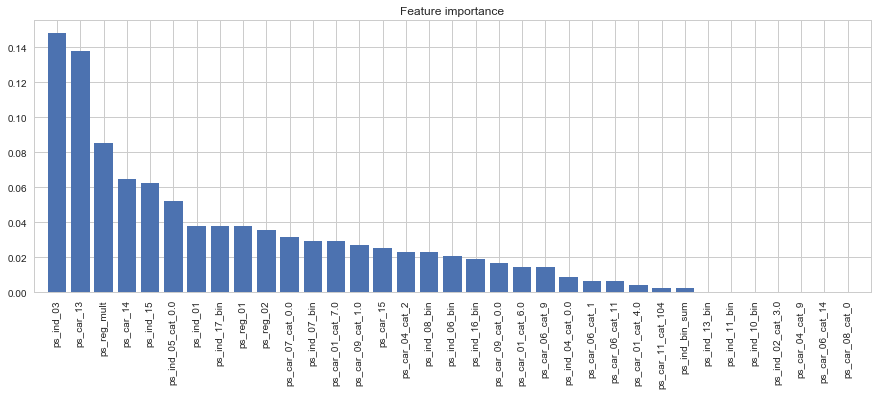

In [39]:
plot_importances(clf_xgb, X_sample.columns[selected])

In [40]:
y_pred = clf_xgb.predict_proba(X_valid_sel)

In [41]:
submission = pd.DataFrame({'id': df_ids, 'target': y_pred[:, 1]})
submission.to_csv('clf_xgb_output.csv', index=False)

In [42]:
joblib.dump(clf_xgb, '../clf_xgb_PS.pkl') 

['../clf_xgb_PS.pkl']

#### LightGBM

In [43]:
import lightgbm as lgb

In [51]:
clf_lgbm_params = {
    'bagging_fraction':     [0.8, 0.9, 1.0],
    'bagging_freq':         [3, 5, 7, 11],
    'n_estimators':         [280, 300, 320],
    'learning_rate':        [0.01, 0.05, 0.1],
    'min_data_in_bin':      [3, 5, 7],
    'num_leaves':           [7, 9, 11],
    'feature_fraction':     [0.3, 0.5, 0.9],
    'max_bin':              [30, 50, 70, 90, 110]
}

In [52]:
clf_lgbm = lgb.LGBMClassifier(random_state=0, is_unbalance=True)
grid = RandomizedSearchCV(clf_lgbm, clf_lgbm_params, scoring=gini_sklearn, n_iter=20, cv=3, verbose=1)
grid.fit(X_sample_sel, y_sample)

print (grid.best_params_)
print (grid.best_score_)

clf_lgbm = grid.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   53.8s finished


{'num_leaves': 9, 'n_estimators': 300, 'min_data_in_bin': 5, 'max_bin': 50, 'learning_rate': 0.01, 'feature_fraction': 0.3, 'bagging_freq': 5, 'bagging_fraction': 0.8}
0.268184605656


In [53]:
clf_lgbm.fit(X_train_sel, y_train)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, boosting_type='gbdt',
        colsample_bytree=1.0, feature_fraction=0.3, is_unbalance=True,
        learning_rate=0.01, max_bin=50, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_data_in_bin=5, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=9, objective=None,
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=50000, subsample_freq=1)

In [54]:
scores = cross_val_score(clf_lgbm, X_test_sel, y_test, scoring=gini_sklearn, cv=3)
print("Gini Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Gini Score: 0.24 (+/- 0.02)


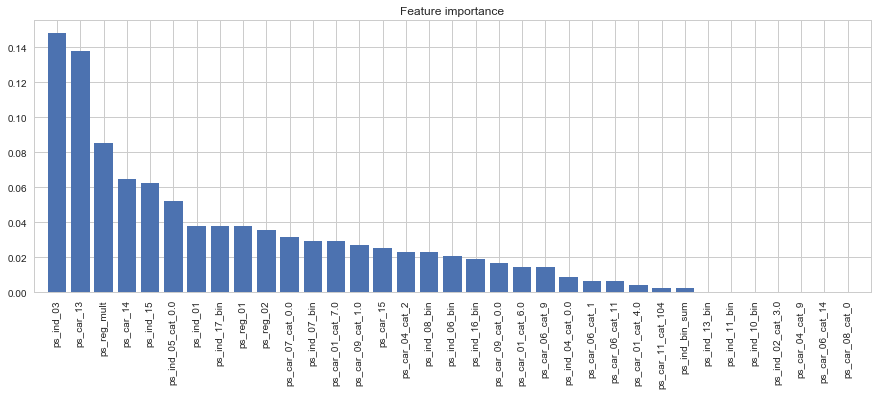

In [55]:
plot_importances(clf_xgb, X_sample.columns[selected])

In [57]:
y_pred = clf_lgbm.predict_proba(X_valid_sel)

In [58]:
submission = pd.DataFrame({'id': df_ids, 'target': y_pred[:, 1]})
submission.to_csv('clf_lgbm_output.csv', index=False)

In [59]:
joblib.dump(clf_lgbm, '../clf_lgbm_PS.pkl') 

['../clf_lgbm_PS.pkl']

#### Stacking

In [60]:
clf_lgbm = joblib.load('../clf_lgbm_PS.pkl') 
clf_xgb =  joblib.load('../clf_xgb_PS.pkl') 

In [61]:
from vecstack import stacking

In [62]:
models = [clf_xgb, clf_lgbm]

In [64]:
S_train, S_valid = stacking(models, X_train_sel, y_train.values, X_valid_sel, regression=True, 
                            metric=gini_normalizedc, n_folds=3, 
                            shuffle=True, random_state=0, verbose=2)

task:   [regression]
metric: [gini_normalizedc]

model 0: [XGBClassifier]
    fold 0: [0.19162512]
    fold 1: [0.19515648]
    fold 2: [0.19324809]
    ----
    MEAN:   [0.19315000]

model 1: [LGBMClassifier]
    fold 0: [0.19247493]
    fold 1: [0.18799866]
    fold 2: [0.18803193]
    ----
    MEAN:   [0.18914212]



In [67]:
clf_stc_params = {
    'learning_rate':      [0.01, 0.05],
    'n_estimators':       [5, 7, 10],
    'max_depth':          [2, 3]
}

In [68]:
clf_stc = xgb.XGBClassifier(silent=1, objective='binary:logistic', seed=0, scale_pos_weight=spw)
grid = GridSearchCV(clf_stc, clf_stc_params, scoring=gini_sklearn, cv=3)
grid.fit(S_train, y_train)

print (grid.best_params_)
print (grid.best_score_)

clf_stc = grid.best_estimator_

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 5}
0.200696828571


In [69]:
y_pred = clf_stc.predict_proba(S_valid)

In [70]:
submission = pd.DataFrame({'id': df_ids, 'target': y_pred[:, 1]})
submission.to_csv('clf_stacking_output.csv', index=False)

#### Voting

In [76]:
from sklearn.ensemble import VotingClassifier

clf_vc = VotingClassifier(estimators=[('xgb', clf_xgb), ('clf_lgbm', clf_lgbm), ('clf_stck', clf_stc)], voting='soft')
clf_vc.fit(X_train_sel, y_train)

VotingClassifier(estimators=[('xgb', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.08, max_delta_step=0, max_depth=2,
       min_child_weight=3, missing=nan, n_estimators=160, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       ..._alpha=0, reg_lambda=1,
       scale_pos_weight=26.392797560835302, seed=0, silent=1, subsample=1))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [77]:
scores = cross_val_score(clf_vc, X_test_sel, y_test, cv=3, scoring=gini_sklearn)
print("Gini Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Gini Score: 0.25 (+/- 0.02)


In [78]:
y_pred = clf_vc.predict_proba(X_valid_sel)

In [79]:
submission = pd.DataFrame({'id': df_ids, 'target': y_pred[:, 1]})
submission.to_csv('clf_vc_output.csv', index=False)

In [80]:
joblib.dump(clf_vc, '../clf_vc_PS.pkl') 

['../clf_vc_PS.pkl']

### Deep Learning

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import EarlyStopping
import keras.backend as K

Using TensorFlow backend.


In [33]:
import keras 
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [34]:
import tensorflow as tf

def gini_keras(y_true, y_pred):
    score, up_opt = tf.metrics.auc(y_true, y_pred) 
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score

In [35]:
model = Sequential()
model.add(BatchNormalization(input_shape=(X_train_sel.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
__________

In [36]:
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')

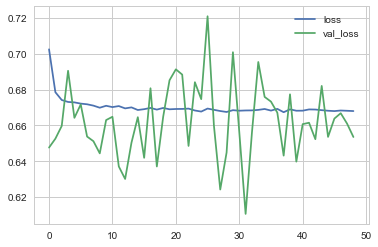

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[gini_keras, 'accuracy'])
hist = model.fit(X_train_sel, y_train, batch_size=128, epochs=100, verbose=0, 
                 validation_data=(X_test_sel, y_test), class_weight=class_weight, callbacks=[plot_losses])

In [ ]:
print('Training GS: %.2f%% / Validation GS: %.2f%%' % (100*hist.history['gini_keras'][-1], 100*hist.history['val_gini_keras'][-1]))

In [ ]:
y_pred = model.predict_proba(X_valid_sel)

In [ ]:
submission = pd.DataFrame({'id': df_ids, 'target': y_pred.flatten})
submission.to_csv('dl_output.csv', index=False)